In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = "../data/DataForML.mat"
mat = scipy.io.loadmat(file_path)

In [3]:
for key in mat.keys():
    print(key)
    # print(type(mat[key]))
    # if isinstance(mat[key], np.ndarray):
    #     print(mat[key].shape)
    # print(mat[key])
Labele_Kompleksni_simboli = mat["Labele_Kompleksni_simboli"]
Labele_Redni_brojevi_simbola = mat["Labele_Redni_brojevi_simbola"]
Simboli_na_prijemu_fazni_offset_uzorak = mat["Simboli_na_prijemu_fazni_offset_uzorak"]
Simboli_na_prijemu_multipath_uzorak = mat["Simboli_na_prijemu_multipath_uzorak"]
Simboli_na_prijemu_uzorak = mat["Simboli_na_prijemu_uzorak"]

__header__
__version__
__globals__
Labele_Kompleksni_simboli
Labele_Redni_brojevi_simbola
Simboli_na_prijemu_fazni_offset_uzorak
Simboli_na_prijemu_multipath_uzorak
Simboli_na_prijemu_uzorak
(65538, 1)
(65538, 1)
(8, 65538)
(8, 65538)
(8, 65538)


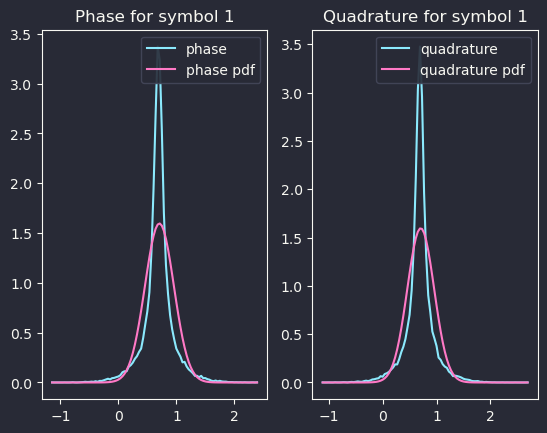

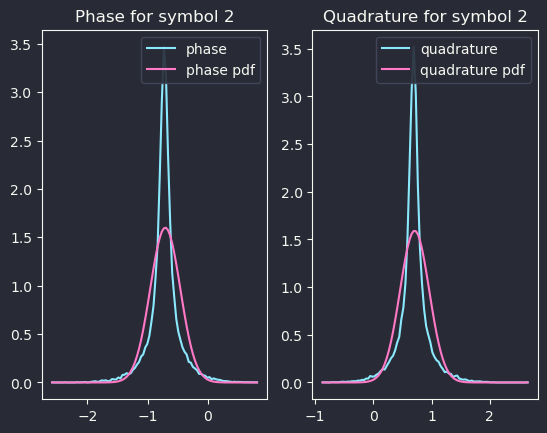

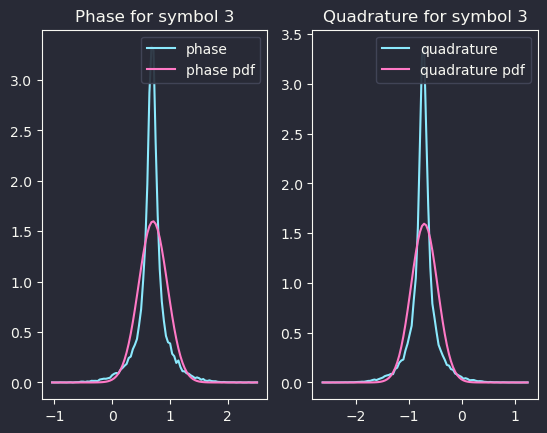

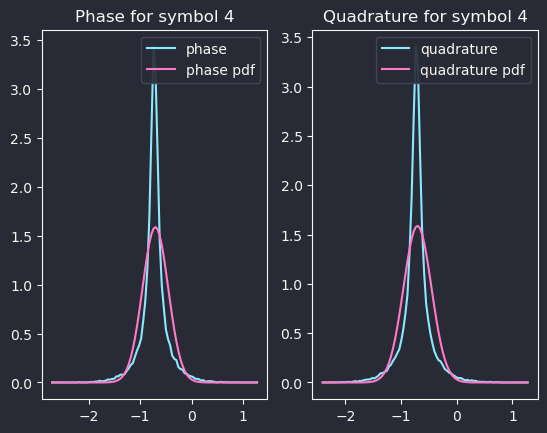

In [36]:
from scipy.stats import norm

train_x = Simboli_na_prijemu_uzorak[:, :20000].flatten()
train_y = Labele_Redni_brojevi_simbola[:20000]
# stack train_y 8 times to match train_x
train_y = np.hstack([train_y for _ in range(8)]).T.flatten()
train_x_phase_all = train_x.real
train_x_quad_all = train_x.imag

symbols = np.unique(train_y)

symbols_phase_avg = np.zeros(len(symbols))
symbols_phase_var = np.zeros(len(symbols))
symbols_quad_avg = np.zeros(len(symbols))
symbols_quad_var = np.zeros(len(symbols))

symbols_prob = np.zeros(len(symbols))

for symbol in symbols:
    train_x_phase = train_x_phase_all[train_y == symbol]
    train_x_quad = train_x_quad_all[train_y == symbol]


    train_x_phase_avg = np.mean(train_x_phase)
    train_x_quad_avg = np.mean(train_x_quad)

    train_x_phase_var = np.mean((train_x_phase - train_x_phase_avg)**2)
    train_x_quad_var = np.mean((train_x_quad - train_x_quad_avg)**2)

    hist, bin_edges = np.histogram(train_x_phase, bins=100,density=True)
    hist/len(train_x_phase)

    plt.subplot(1,2,1)
    plt.title(f'Phase for symbol {symbol}')
    plt.plot(bin_edges[:-1], hist, label='phase')
    plt.plot(bin_edges[:-1], norm.pdf(bin_edges[:-1], train_x_phase_avg, train_x_phase_var**0.5), label='phase pdf')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title(f'Quadrature for symbol {symbol}')
    hist, bin_edges = np.histogram(train_x_quad, bins=100,density=True)
    hist/len(train_x_quad)
    plt.plot(bin_edges[:-1], hist, label='quadrature')
    plt.plot(bin_edges[:-1], norm.pdf(bin_edges[:-1], train_x_quad_avg, train_x_quad_var**0.5), label='quadrature pdf')
    plt.legend()
    plt.show()

    symbol -= 1
    symbols_phase_avg[symbol] = train_x_phase_avg
    symbols_phase_var[symbol] = train_x_phase_var
    symbols_quad_avg[symbol] = train_x_quad_avg
    symbols_quad_var[symbol] = train_x_quad_var
    symbols_prob[symbol] = len(train_x_phase) / len(train_x)


[0.25025 0.2509  0.24615 0.2527 ]
[[6061  100   94    3]
 [ 100 6059    3   89]
 [  85    3 5977   90]
 [   1   85  105 6145]]


/tmp/ipykernel_7645/3515121376.py:17: RuntimeWarning: divide by zero encountered in log
  pPhaseSymbol[..., symbol] = np.log(norm.pdf(test_x.real, loc=symbols_phase_avg[symbol], scale=symbols_phase_var[symbol]))
/tmp/ipykernel_7645/3515121376.py:18: RuntimeWarning: divide by zero encountered in log
  pQuadSymbol[..., symbol] = np.log(norm.pdf(test_x.imag, loc=symbols_quad_avg[symbol], scale=symbols_quad_var[symbol]))


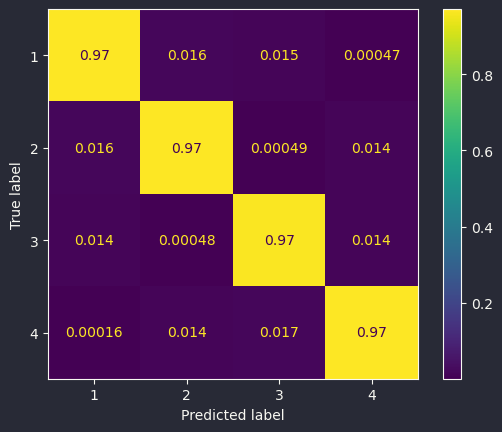

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
validation_x = train_x[20000:25000]
validation_y = train_y[20000:25000]

test_x = train_x[25000:50000]
test_y = train_y[25000:50000]

print(symbols_prob)


pPhaseSymbol = np.zeros(test_x.shape + (len(symbols),))
pQuadSymbol = np.zeros(test_x.shape + (len(symbols),))

for symbol in symbols:
    symbol -= 1
    pPhaseSymbol[..., symbol] = np.log(norm.pdf(test_x.real, loc=symbols_phase_avg[symbol], scale=symbols_phase_var[symbol]))
    pQuadSymbol[..., symbol] = np.log(norm.pdf(test_x.imag, loc=symbols_quad_avg[symbol], scale=symbols_quad_var[symbol]))

pSymbol = np.zeros(test_x.shape + (len(symbols),))
for symbol in symbols:
    symbol -= 1
    pSymbol[..., symbol] = np.log(symbols_prob[symbol]) + pQuadSymbol[..., symbol] + pPhaseSymbol[..., symbol] + 1e-10

predicted_y = np.argmax(pSymbol, axis=-1) + 1
matrix_confusion = confusion_matrix(test_y, predicted_y)
print(matrix_confusion)
ConfusionMatrixDisplay.from_predictions(test_y, predicted_y, normalize='pred')
plt.show()